In [11]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter

In [12]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper


# TODO: update once FermionicOp supports Parameters. See Github Issue: https://github.com/Qiskit/qiskit-nature/issues/828
def compute_H_secondquant(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges by first
        defining the system with a FermionicOp object followed by a JordanWigner transform.

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        pauli_H - PauliSumOp; the Hamiltonian in Pauli operators
    """
    second_quant_H = 0
    for site in range(num_sites - 1):
        if site in defect_locs:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau_d
        else:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H


# Example computation
compute_H_secondquant(-1, -0.5, 2, [0])

PauliSumOp(SparsePauliOp(['YY', 'XX'],
              coeffs=[-0.25+0.j, -0.25+0.j]), coeff=1.0)

In [13]:
def compute_H(tau, num_sites):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        H - SummedOp; the Hamiltonian
    """

    H = 0
    for i in range(num_sites - 1):
        # if i in defect_locs:
        #     H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
        #     H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
        # else:
        H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
        H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 2
defect_location = [0]

# Parameterized hopping strengths
tau = Parameter("τ")
H_param = compute_H(tau, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({tau: 1})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('XX'), coeff=-0.5), PauliOp(Pauli('YY'), coeff=-0.5)], coeff=1.0, abelian=False)

In [14]:
# Define a list of number operators in terms of Pauli operators
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]

def exact_time_evolution(H,obseravble, initial_state, times, num_sites):
    evo_matrix = np.zeros((len(times), num_sites))
    var_matrix = np.zeros(len(times))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(obseravble):
            # Compute the time evolution operator U(time) at time time
            U = (H *time).exp_i()
            # Compute the evolution of the initial state
            final_state = U @ initial_state
            # Compute the expectation value n_i
            evo_matrix[i, j] = np.abs((final_state.adjoint() @ oi @ final_state).eval())
        var_matrix[i] = (
            np.abs((final_state.adjoint() @ (sum(obseravble) @ sum(obseravble)) @ final_state).eval())
            - np.abs((final_state.adjoint() @ sum(obseravble) @ final_state).eval()) ** 2
        )
    return evo_matrix, var_matrix

# Plot the time evolution
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)
H_1 = H_param.bind_parameters({tau: 0.5})   
H_2 = H_param.bind_parameters({tau: 1})   

initial_state_1 = One ^ Zero
n_t05_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_1, times, num_sites)
n_t1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_1, times, num_sites)

initial_state_2 = One ^ One
n_t05_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_2, times, num_sites)
n_t1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_2, times, num_sites)


100%|██████████| 500/500 [00:04<00:00, 106.97it/s]


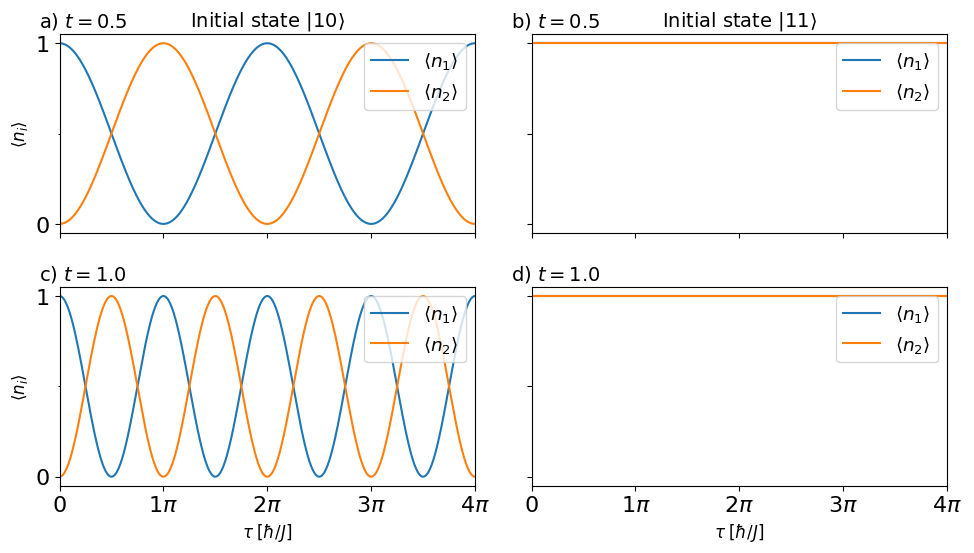

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plotting Setup ---
# Assuming 'times' and the four 'n_..._evo_matrix_...' variables exist
num_sites = 3

# Define plot labels and ticks
num_op_labels = [r"$\langle n_" + str(i+1) + r"\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, time_max * np.pi, time_max+1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max+1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1']

# --- Create 2x2 Subplot Grid ---
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

# --- Column 1: Initial State |11> ---
axs[0, 0].plot(times, n_t05_evo_matrix_state_1)
axs[1, 0].plot(times, n_t1_evo_matrix_state_1)
axs[0, 0].set_title(r"Initial state $|10\rangle$", fontsize=14)

# --- Column 2: Initial State |00> ---
axs[0, 1].plot(times, n_t05_evo_matrix_state_2)
axs[1, 1].plot(times, n_t1_evo_matrix_state_2)
axs[0, 1].set_title(r"Initial state $|11\rangle$", fontsize=14)

# --- Row & Corner Labels ---
corner_labels = [[r'a) $t=0.5$', r'b) $t=0.5$'], [r'c) $t=1.0$', r'd) $t=1.0$']]
tau_labels = [r"$t=0.5$", r"$t=1.0$"]

for r in range(2):
    axs[r, 0].set_ylabel(rf"$\langle n_i \rangle$", fontsize=12)
    axs[1, r].set_xlabel(rf"$\tau \; [\hbar/J]$", fontsize=12)

    for c in range(2):
        axs[r, c].text(-0.05, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
        
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    #ax.grid(linestyle='--', alpha=0.6)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
for ax in axs[1, :]:  # Bottom row
    ax.set_xticklabels(xtick_labels)
for ax in axs[:, 0]:  # Left column
    ax.set_yticklabels(ytick_labels)

# --- CORRECTED: Customize Y-Tick Length ---
# Get the default major tick length to use as a reference
default_tick_length = plt.rcParams['ytick.major.size']

# Loop through the axes in the left column where y-ticks are visible
for ax in axs[:, 0]:
    # Get the list of major tick objects for the y-axis
    y_ticks = ax.yaxis.get_major_ticks()
    for tick in y_ticks:
        # Check if the tick's position is 0.5
        if tick.get_loc() == 0.5:
            # CORRECT: Modify the 'markersize' of the tick's line object
            tick.tick1line.set_markersize(default_tick_length / 2)


# --- Final Figure Adjustments ---
handles, _ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, num_op_labels, loc='upper right', 
           bbox_to_anchor=(0.99, 0.96), frameon=False) # Add frameon=False
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('figures/2-site-tb/site-prob-multi-11.pdf')
# --- Display the plot ---
plt.show()

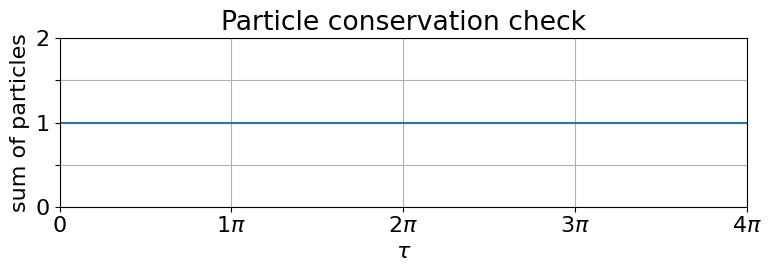

In [16]:
plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_t1_evo_matrix_state_1, axis=1))
plt.xlabel(r"$\tau$")
plt.ylabel("sum of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.xlim([0, time_max * np.pi])
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.tight_layout()
plt.savefig("figures/2-site-tb/particle-cons-check.pdf")
plt.show()

### Draw circuit

In [17]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks
    
U1 = compute_U_trot(H_2, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-site-circuit.tex", "w") as f:
    f.write(latex_code)

NameError: name 'compute_U_trot' is not defined